In [ ]:
from cil.io.utilities import HDF5_utilities
from cil.utilities.display import show2D, show_geometry
from cil.framework import AcquisitionData, AcquisitionGeometry, DataContainer
from cil.utilities.jupyter import islicer
from cil.plugins.astra.processors import FBP
from cil.plugins.astra.operators import ProjectionOperator
from cil.processors import Normaliser, TransmissionAbsorptionConverter

from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import h5py
import numpy as np
import os
import scipy

In [34]:
filepath = '/mnt/share/ALC_laminography/folder/combined_data/k11-54286.nxs'

In [35]:
HDF5_utilities.print_metadata(filepath)

	 - entry : <HDF5 group "/entry" (3 members)>
		 - imaging : <HDF5 group "/entry/imaging" (1 members)>
			 - data : <HDF5 dataset "data": shape (1481, 540, 640), type "<i4">
		 - imaging_sum : <HDF5 group "/entry/imaging_sum" (1 members)>
			 - smaract_zrot : <HDF5 dataset "smaract_zrot": shape (1481,), type "<f8">
		 - instrument : <HDF5 group "/entry/instrument" (1 members)>
			 - EtherCAT : <HDF5 group "/entry/instrument/EtherCAT" (1 members)>
				 - image_key : <HDF5 dataset "image_key": shape (1481,), type "<i4">


In [36]:
key = HDF5_utilities.read(filename=filepath, dset_path='entry/instrument/EtherCAT/image_key')

In [37]:
angles = HDF5_utilities.read(filename=filepath, dset_path='/entry/imaging_sum/smaract_zrot')

In [38]:
data = HDF5_utilities.read(filename=filepath, dset_path='/entry/imaging/data', source_sel=(key == 0,))
flat = HDF5_utilities.read(filename=filepath, dset_path='/entry/imaging/data', source_sel=(key == 1,))
dark = HDF5_utilities.read(filename=filepath, dset_path='/entry/imaging/data', source_sel=(key == 2,))

In [39]:
ag = AcquisitionGeometry.create_Parallel3D()
ag.set_angles(angles[key==0,])
ag.set_panel([data.shape[2], data.shape[1]])

data = AcquisitionData(data, geometry=ag)

In [40]:
processor = Normaliser(flat_field=flat.mean(axis=0), dark_field=dark.mean(axis=0))
processor.set_input(data)
data_norm = processor.get_output()

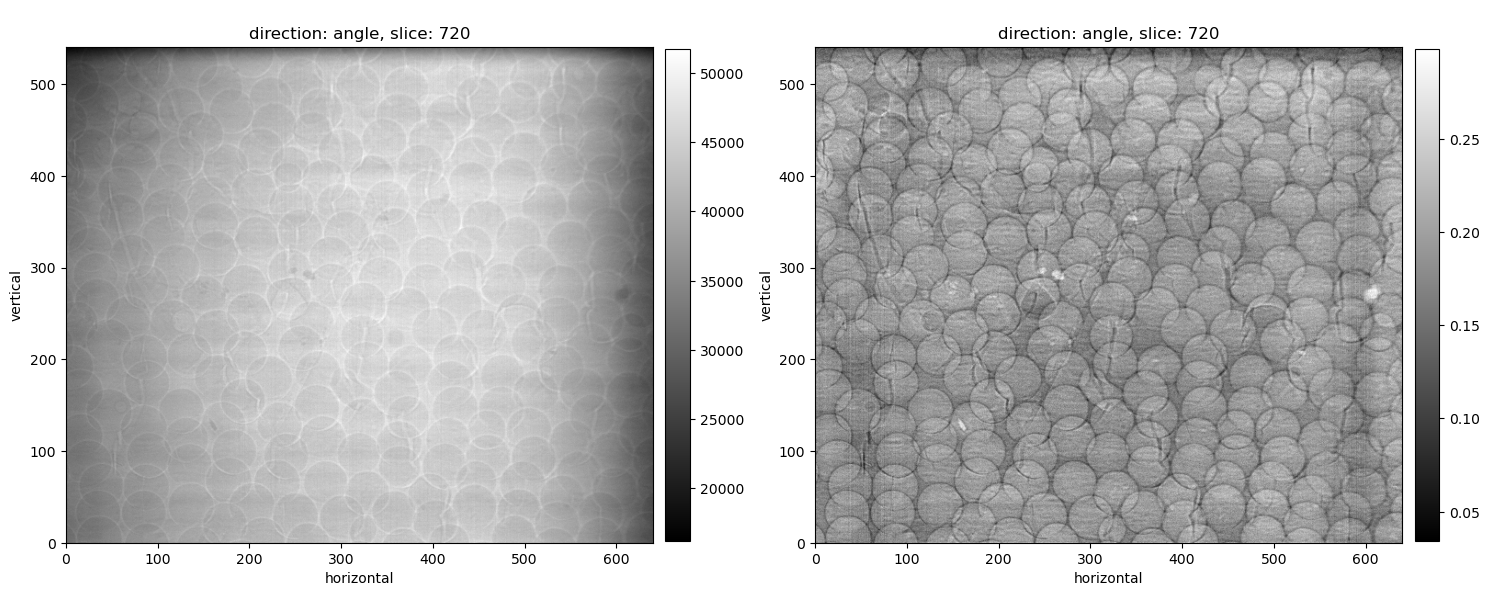

In [41]:
processor = TransmissionAbsorptionConverter()
processor.set_input(data_norm)
processor.get_output(out=data_norm)
show2D([data, data_norm])

In [64]:
islicer(data_norm)

In [67]:
[0,-np.sin(tilt), np.cos(tilt)]

[0, 0.428182669496151, -0.9036922050915067]

In [74]:


tilt_direction = np.array([1, 0, 0])
orthogonal_axis = ag.config.system.detector.direction_y


array([0.        , 0.46947156, 0.88294759])

In [ ]:
data_norm.reorder('astra')

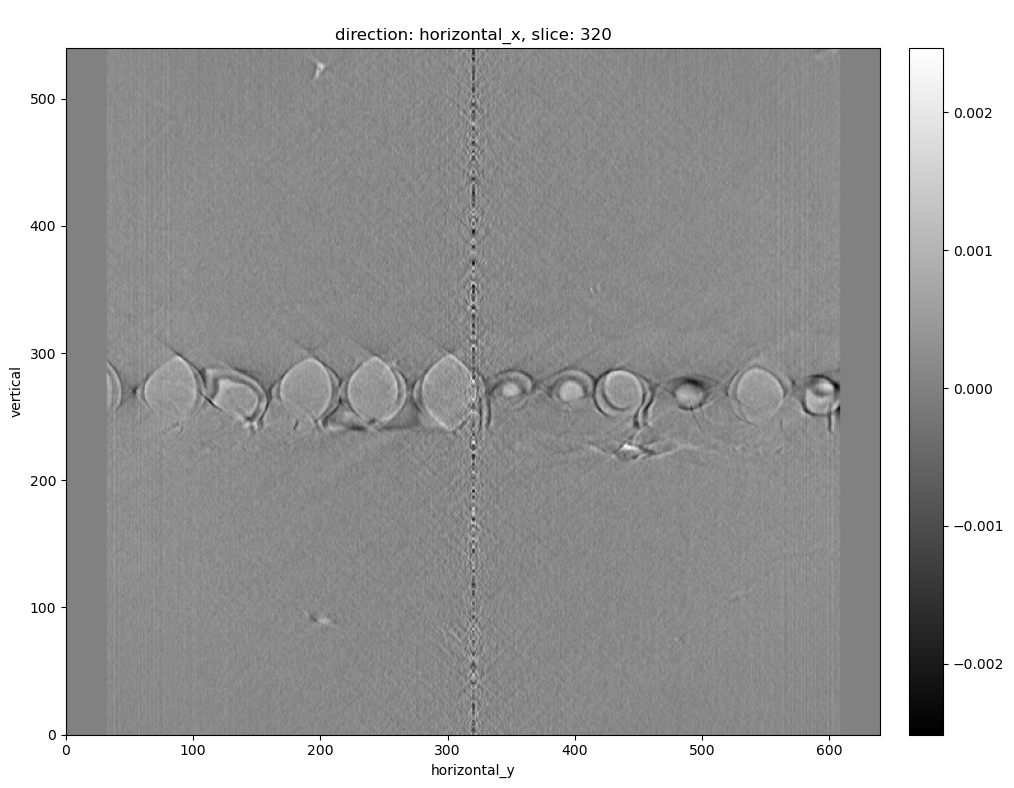

In [115]:

tilt = -36

rotation_matrix = R.from_rotvec(np.radians(tilt) * tilt_direction)
rotation_axis = rotation_matrix.apply(orthogonal_axis)
data_norm.geometry.config.system.rotation_axis.direction = rotation_axis
ig = data_norm.geometry.get_ImageGeometry()
# ig.voxel_num_z = 1

fbp = FBP(ig, data_norm.geometry)
fbp.set_input(data_norm)
recon = fbp.get_output()
recon.apply_circular_mask(0.9)
show2D(recon, slice_list=('horizontal_x',320))

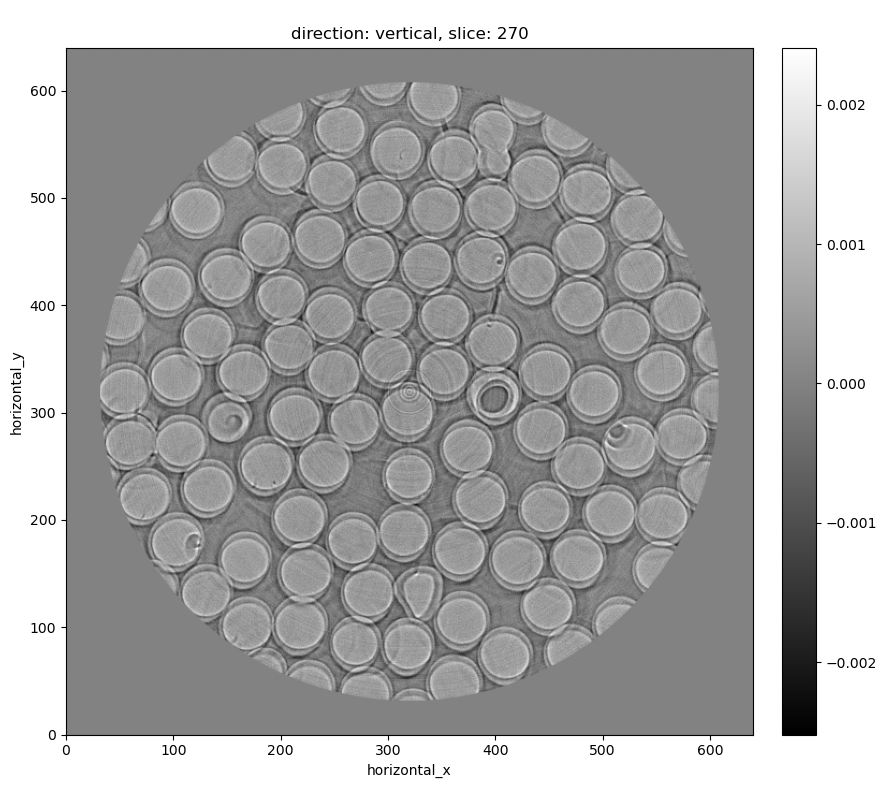

In [116]:
show2D(recon)

In [23]:
data_norm.reorder('astra')
ag = data_norm.geometry
ig = ag.get_ImageGeometry()

In [24]:
data_norm.reorder('cil')

In [25]:
data_filtered = data_norm.copy()
data_filtered.fill(scipy.ndimage.sobel(data_norm.as_array(), axis=0, mode='reflect', cval=0.0))

In [26]:
islicer(data_filtered)

In [93]:
data_filtered.reorder('astra')
data_norm.reorder('astra')
ag = data_norm.geometry

[0.         0.59482279 0.80385686]


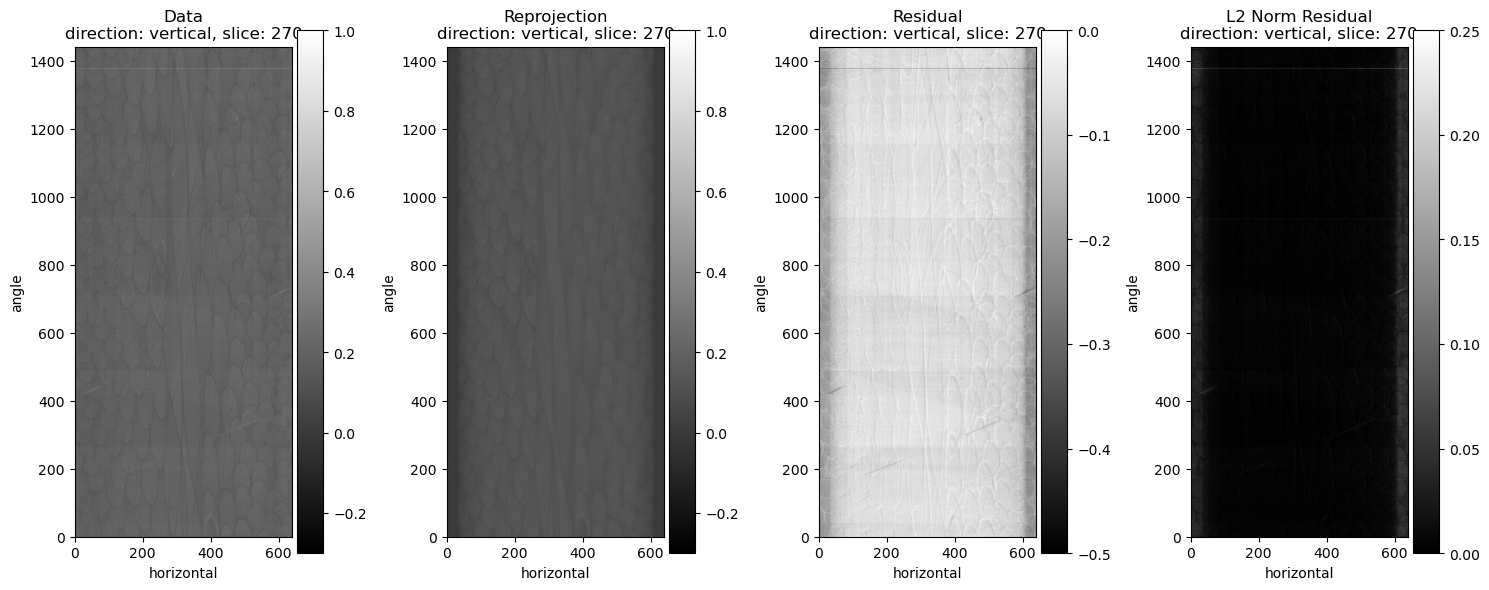

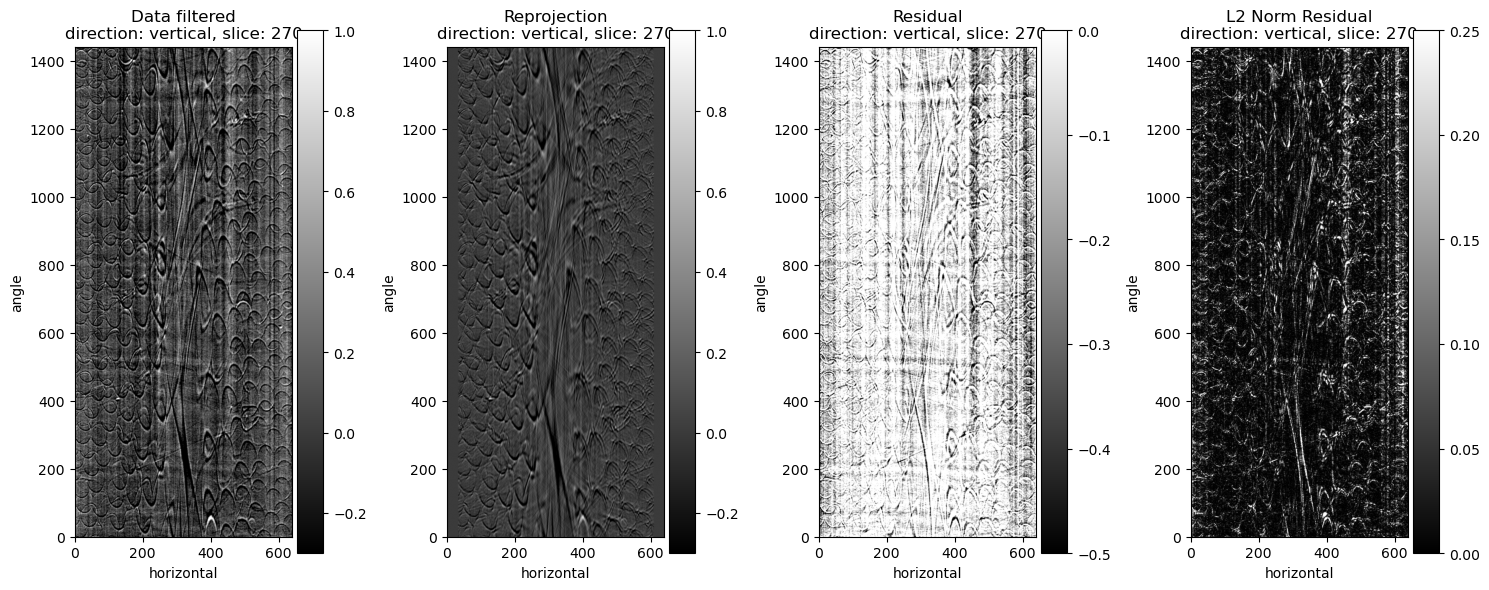

[0.         0.60181502 0.79863551]


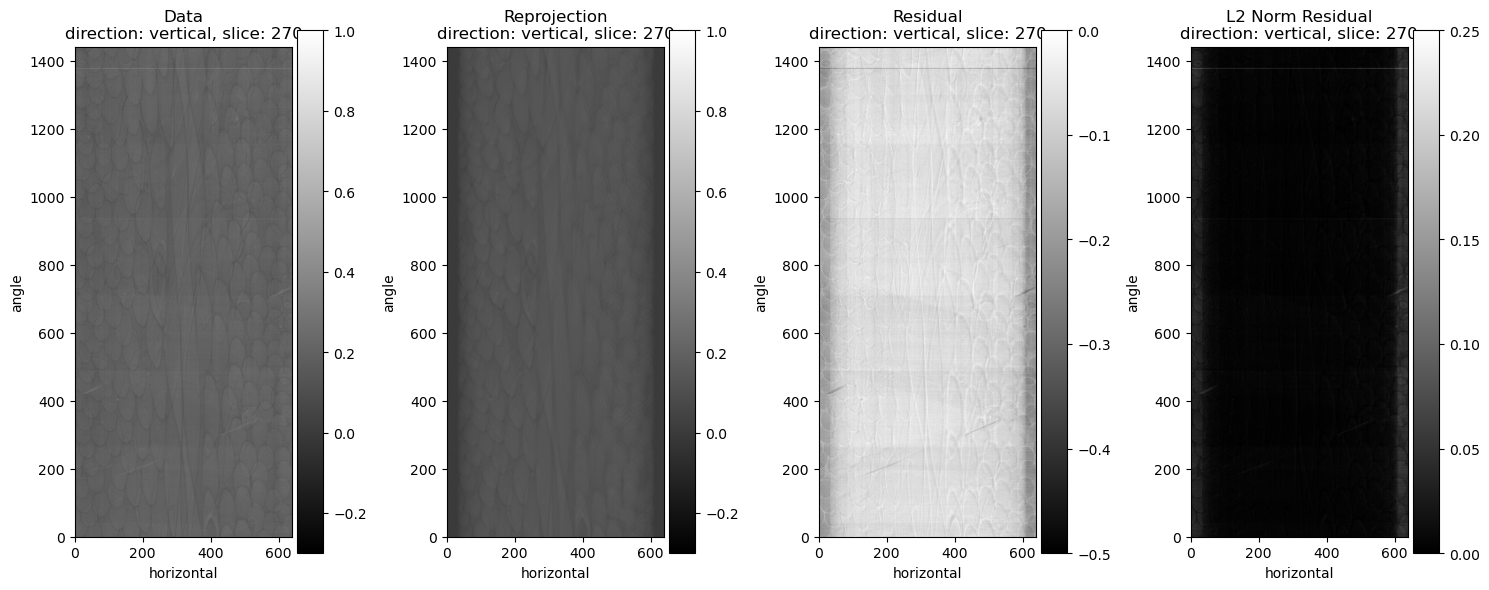

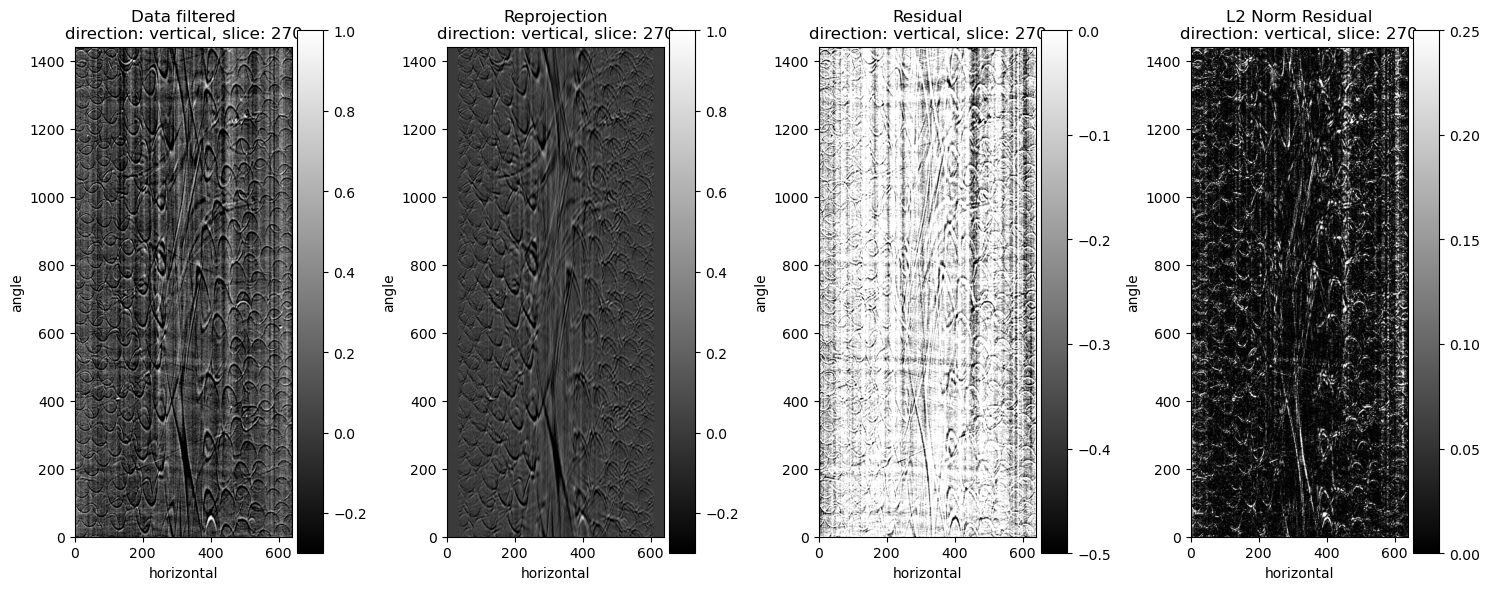

[0.         0.60876143 0.79335334]


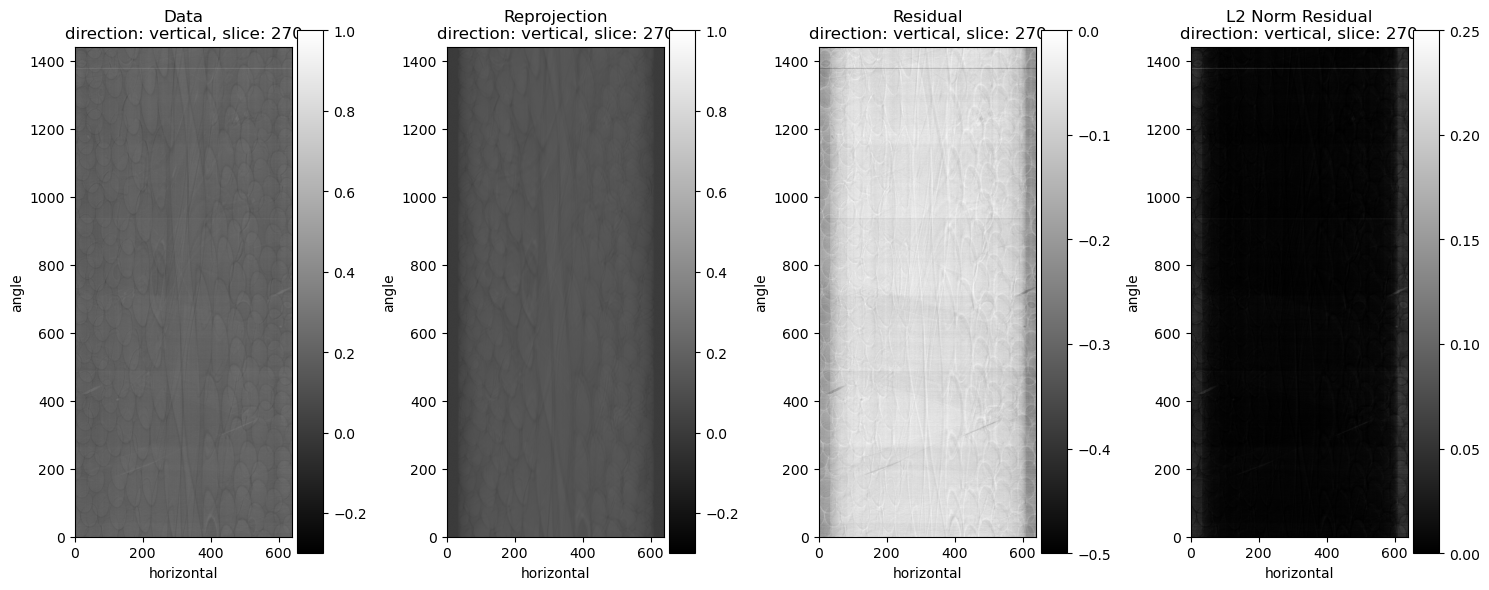

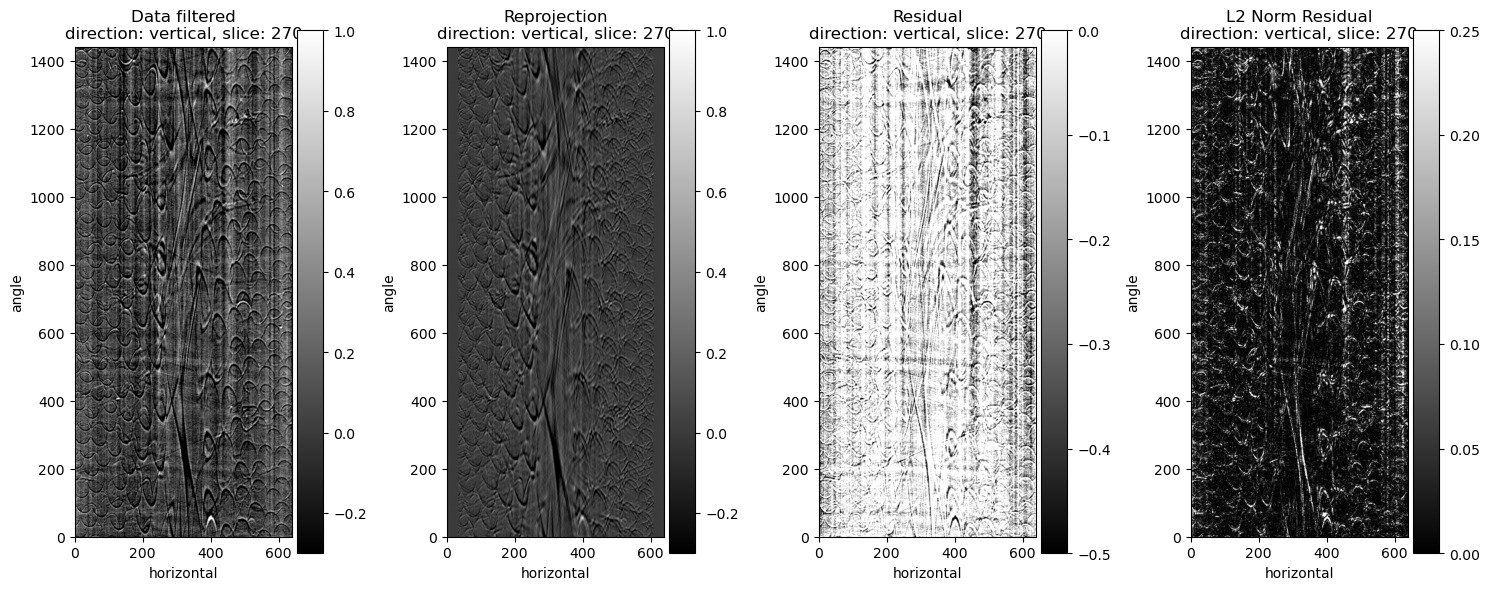

In [105]:
losses = []
losses_filtered = []

data_filtered = data_norm.copy()
data_filtered.fill(scipy.ndimage.sobel(data_norm.as_array(), axis=0, mode='reflect', cval=0.0))

# tilts = np.array([20.0, 22, 24, 26, 28, 28.5, 29, 29.2, 29.4, 29.6, 29.8, 30.0, 30.2, 30.4, 30.6, 30.8, 31., 31.5, 32, 34, 36., 38, 40.0 ])
# tilts = np.arange(-36.0, -33.1, 0.5)
tilts = [-36.5, -37, -37.5]
for tilt in tilts:
    ag_tilt = ag.copy()

    rotation_matrix = R.from_rotvec(np.radians(tilt) * tilt_direction)
    rotation_axis = rotation_matrix.apply(orthogonal_axis)
    ag_tilt.config.system.rotation_axis.direction = rotation_axis
    print(ag_tilt.config.system.rotation_axis.direction)

    ig = ag_tilt.get_ImageGeometry()
    # ig.voxel_num_z = 1 

    # Unfiltered
    fbp = FBP(ig, ag_tilt)
    fbp.set_input(data_norm)
    recon = fbp.get_output()
    recon.apply_circular_mask(0.9)

    A = ProjectionOperator(ig, ag_tilt)
    reprojection = A.direct(recon)
    residual = reprojection - data_norm

    show2D([data_norm, reprojection, residual, residual**2], num_cols=4,
           title=['Data', 'Reprojection', 'Residual', 'L2 Norm Residual'], 
           fix_range=[(-0.3, 1), (-0.3, 1), (-0.5, 0), (0, 0.25)])
    
    loss = (residual ** 2).sum()
    losses.append(loss)

    # Filtered
    fbp = FBP(ig, ag_tilt)
    fbp.set_input(data_filtered)
    recon_filtered = fbp.get_output()
    recon_filtered.apply_circular_mask(0.9)

    A = ProjectionOperator(ig, ag_tilt)
    reprojection = A.direct(recon_filtered)
    residual = reprojection - data_filtered

    show2D([data_filtered, reprojection, residual, residual**2], num_cols=4,
           title=['Data filtered', 'Reprojection', 'Residual', 'L2 Norm Residual'], 
           fix_range=[(-0.3, 1), (-0.3, 1), (-0.5, 0), (0, 0.25)])
    
    # show2D([data_filtered, reprojection, residual_centered, residual_centered**2], num_cols=4,
    #        title=['Data filtered', 'Reprojection', 'Residual', 'L2 Norm Residual'], 
    #        fix_range=[(-0.3, 1), (-0.3, 1), (-0.5, 0), (0, 0.25)])
    
    loss = (residual ** 2).sum()
    losses_filtered.append(loss)

In [111]:
tilts = np.array([-36. , -35.5, -35. , -34.5, -34. , -33.5, -36.5, -37, -37.5])

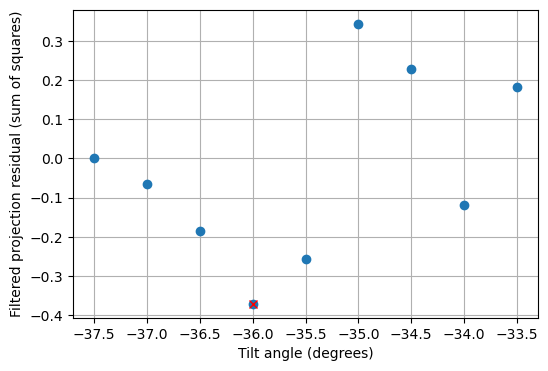

In [113]:
A = np.array(losses_filtered)
A = (A - A.min()) / (A.max() - A.min())
B = np.array(losses)
B = (B - B.min()) / (B.max() - B.min())

plt.figure(figsize=(6, 4))
plt.plot(tilts, A-B, 'o')
plt.xlabel("Tilt angle (degrees)")
plt.ylabel("Filtered projection residual (sum of squares)")
plt.grid()
plt.plot(tilts[np.argmin(A-B)], np.min(A-B), 'rx')

In [ ]:
offset = 0

recon_filtered_list = []
recon_list = []
tilts = np.arange(-35.0, -30.1, 0.5)

tilt_direction = np.array([1, 0, 0])
orthogonal_axis = ag.config.system.detector.direction_y

evaluation = np.zeros(len(tilts))
evaluation_filtered = np.zeros(len(tilts))
for i, tilt in enumerate(tilts):
    ag_tilt = ag.copy()
    ag_tilt.set_centre_of_rotation(offset=offset)

    rotation_matrix = R.from_rotvec(np.radians(tilt) * tilt_direction)
    rotation_axis = rotation_matrix.apply(orthogonal_axis)
    ag_tilt.config.system.rotation_axis.direction = rotation_axis
    ig_tilt = ag_tilt.get_ImageGeometry()
    ig_tilt.voxel_num_z = 1

    fbp = FBP(ig_tilt, ag_tilt)
    fbp.set_input(data_filtered)
    recon_filtered = fbp.get_output()
    recon_filtered.apply_circular_mask(0.9)
    recon_filtered_list.append(recon_filtered.array)
    evaluation_filtered[i] = (recon_filtered*recon_filtered).sum()

    fbp.set_input(data_norm)
    recon = fbp.get_output()
    recon.apply_circular_mask(0.9)
    recon_list.append(recon.array)

    evaluation[i] = (recon*recon).sum()

DC_filtered = DataContainer(np.stack(recon_filtered_list, axis=0), dimension_labels=('Tilt',) + recon_filtered.geometry.dimension_labels)
DC_recon = DataContainer(np.stack(recon_list, axis=0), dimension_labels=('Tilt',) + recon.geometry.dimension_labels)

Text(0, 0.5, 'Filtered/Unfiltered normalised')

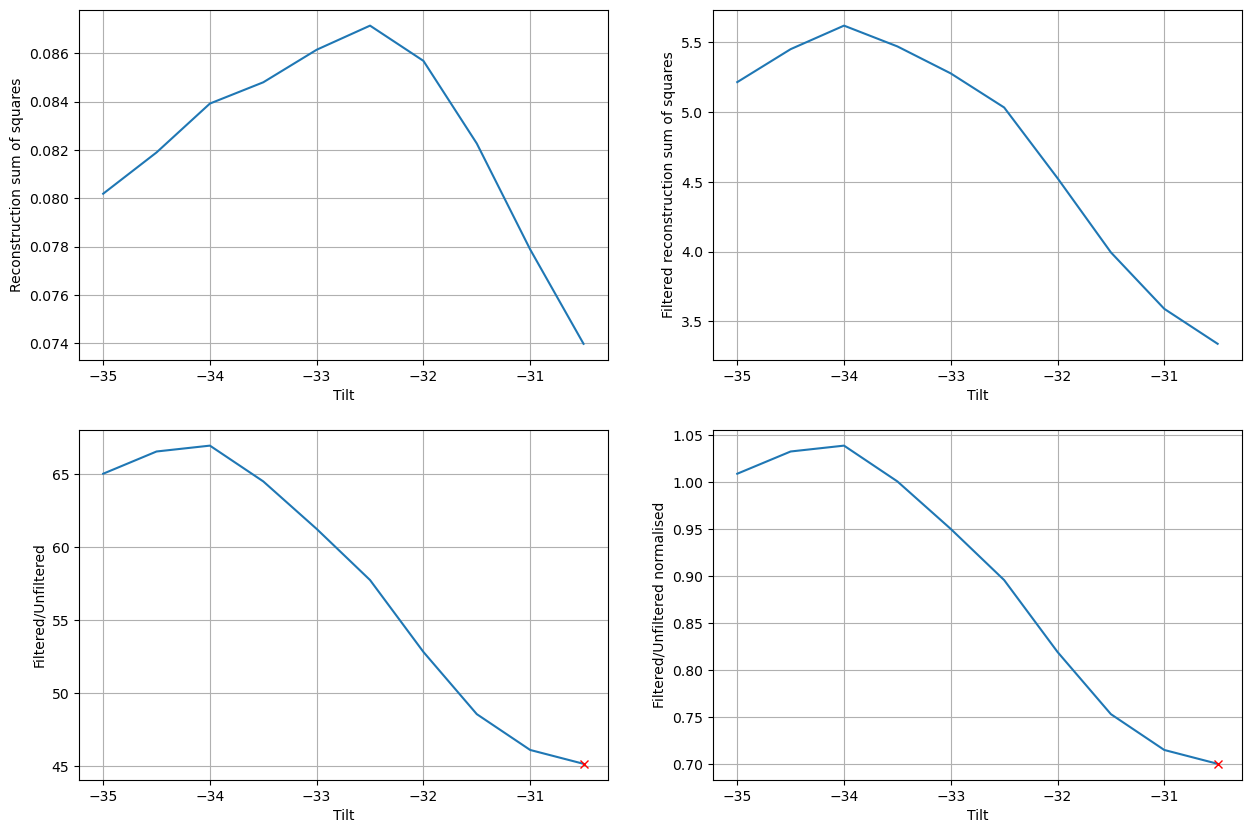

In [95]:
[fig, axs] = plt.subplots(2,2, figsize=(15,10))
ax = axs[0,0]
ax.plot(tilts, evaluation)
ax.grid()
ax.set_xlabel('Tilt')
ax.set_ylabel('Reconstruction sum of squares')

ax = axs[0,1]
ax.plot(tilts, evaluation_filtered)
ax.grid()
ax.set_xlabel('Tilt')
ax.set_ylabel('Filtered reconstruction sum of squares')

ax = axs[1,0]
y = evaluation_filtered/evaluation
ax.plot(tilts, y)
ax.plot(tilts[y.argmin()], y[y.argmin()], 'rx')
ax.grid()
ax.set_xlabel('Tilt')
ax.set_ylabel('Filtered/Unfiltered')

ax = axs[1,1]
y = (evaluation_filtered/evaluation_filtered.max())/(evaluation/evaluation.max())
ax.plot(tilts, y)
ax.plot(tilts[y.argmin()], y[y.argmin()], 'rx')
ax.grid()
ax.set_xlabel('Tilt')
ax.set_ylabel('Filtered/Unfiltered normalised')

In [96]:
islicer(DC_recon, title=tuple(['Centre of rotation offset: ' + str(t)  + ', index: ' for t in tilts]))

In [31]:
islicer(DC_filtered, title=tuple(['Centre of rotation offset: ' + str(t)  + ', index: ' for t in tilts]))

In [32]:
tilt = 34.0

recon_filtered_list_rot = []
recon_list_rot = []
offsets = [-4, -3.5, -3.4, -3.3, -3.2, -3.1, -3.0, -2.9, -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2, -1.5]
evaluation_filtered_rot = np.zeros(len(offsets))
evaluation_rot = np.zeros(len(offsets))
for i, offset in enumerate(offsets):
    ag_tilt = ag.copy()
    ag_tilt.set_centre_of_rotation(offset=offset)
    ag_tilt.config.system.rotation_axis.direction = [0,-np.sin(tilt), np.cos(tilt)]
    ig_tilt = ag_tilt.get_ImageGeometry()
    ig_tilt.voxel_num_z = 1

    fbp = FBP(ig_tilt, ag_tilt)
    fbp.set_input(data_filtered)
    recon_filtered = fbp.get_output()
    recon_filtered.apply_circular_mask(0.9)
    recon_filtered_list_rot.append(recon_filtered.array)
    evaluation_filtered_rot[i] = (recon_filtered*recon_filtered).sum()

    fbp.set_input(data_norm)
    recon = fbp.get_output()
    recon.apply_circular_mask(0.9)
    recon_list_rot.append(recon.array)
    evaluation_rot[i] = (recon*recon).sum()

DC_filtered_rot = DataContainer(np.stack(recon_filtered_list_rot, axis=0), dimension_labels=('Offset',) + recon_filtered.geometry.dimension_labels)
DC_recon_rot = DataContainer(np.stack(recon_list_rot, axis=0), dimension_labels=('Offset',) + recon.geometry.dimension_labels)

KeyboardInterrupt: 

In [ ]:
# plt.plot(offsets, evaluation_rot)
# plt.plot(offsets[evaluation_rot.argmax()], evaluation_rot[evaluation_rot.argmax()], 'rx')
# plt.grid()

# plt.figure()
plt.plot(offsets, evaluation_filtered_rot)
plt.plot(offsets[evaluation_filtered_rot.argmax()], evaluation_filtered_rot[evaluation_filtered_rot.argmax()], 'rx')
plt.grid()

In [ ]:
offsets[evaluation_filtered_rot.argmax()]

In [ ]:
islicer(DC_recon_rot, title=tuple(['Centre of rotation offset: ' + str(t)  + ', index: ' for t in offsets]))

In [ ]:
islicer(DC_filtered_rot, title=tuple(['Centre of rotation offset: ' + str(t)  + ', index: ' for t in offsets]))

In [ ]:
offset = -3.3
tilt = 34.0

ag_tilt = ag.copy()
ag_tilt.set_centre_of_rotation(offset=offset)
ag_tilt.config.system.rotation_axis.direction = [0,-np.sin(tilt), np.cos(tilt)]
ig_tilt = ag_tilt.get_ImageGeometry()

In [ ]:
print(ag)

In [ ]:
fbp = FBP(ig_tilt, ag_tilt)
fbp.set_input(data_norm)
recon = fbp.get_output()